In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import praw
import matplotlib.pyplot as plt
import math
import datetime as dt
import pandas as pd
import numpy as np
import re
import requests

In [ ]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

In [ ]:
from Reddit_api import *

reddit = praw.Reddit(client_id=REDDIT_client_id,
                    client_secret=REDDIT_client_secret,
                    user_agent=REDDIT_user_agent, 
                    check_for_async=False)

In [ ]:
df = []

for post in reddit.subreddit('wallstreetbets').hot(limit=500):
    
    content = {
        "title" : post.title,
        "text" : post.selftext
    }
    
    df.append(content)

df = pd.DataFrame(df)

In [ ]:
regex = re.compile('[^a-zA-Z ]')
word_dict = {}

for (index, row) in df.iterrows():
    # titles
    title = row['title']
    
    title = regex.sub('', title)
    title_words = title.split(' ')
    
    # content
    content = row['text']
    
    content = regex.sub('', content)
    content_words = content.split(' ')
    
    # combine
    words = title_words + content_words
    
    for x in words:
        
        if x in ['A', 'B', 'GO', 'ARE', 'ON', 'IT', 'ALL', 'NEXT', 'PUMP', 'AT', 'NOW', 'FOR', 'TD', 'CEO', 'AM', 'K', 'BIG', 'BY', 'LOVE', 'CAN', 'BE', 'SO', 'OUT', 'STAY', 'OR', 'NEW','RH','EDIT','ONE','ANY']:
            pass
        elif x in word_dict:
            word_dict[x] += 1
        else:
            word_dict[x] = 1

word_df = pd.DataFrame.from_dict(list(word_dict.items())).rename(columns = {0:"Term", 1:"Frequency"})

In [ ]:
ticker_data = pd.read_csv('./tickerlist.csv')
ticker_data.head(5)

In [ ]:
ticker_df = ticker_data.rename(columns = {"Symbol":"Term", "Name":"Company_Name"})
ticker_df.head(5)

In [ ]:
stonks_df = pd.merge(ticker_df, word_df, on="Term")

In [ ]:
stonks_df = stonks_df.sort_values(by="Frequency", ascending = False, ignore_index = True).head(20)

In [ ]:
output = "\n\n~~Top 10 Stonks on WSB~~\n"+ "1) "+ stonks_df['Company_Name'][0] + " (" + stonks_df['Term'][0] + ") " + " - " + str(stonks_df['Frequency'][0]) + " mentions\n"+ "2) "+ stonks_df['Company_Name'][1] + " (" + stonks_df['Term'][1] + ") " + " - " + str(stonks_df['Frequency'][1]) + " mentions\n"+ "3) "+ stonks_df['Company_Name'][2] + " (" + stonks_df['Term'][2] + ") " + " - " + str(stonks_df['Frequency'][2]) + " mentions\n"+ "4) "+ stonks_df['Company_Name'][3] + " (" + stonks_df['Term'][3] + ") " + " - " + str(stonks_df['Frequency'][3]) + " mentions\n"+ "5) "+ stonks_df['Company_Name'][4] + " (" + stonks_df['Term'][4] + ") " + " - " + str(stonks_df['Frequency'][4]) + " mentions\n"+ "6) "+ stonks_df['Company_Name'][5] + " (" + stonks_df['Term'][5] + ") " + " - " + str(stonks_df['Frequency'][5]) + " mentions\n"+ "7) "+ stonks_df['Company_Name'][6] + " (" + stonks_df['Term'][6] + ") " + " - " + str(stonks_df['Frequency'][6]) + " mentions\n"+ "8) "+ stonks_df['Company_Name'][7] + " (" + stonks_df['Term'][7] + ") " + " - " + str(stonks_df['Frequency'][7]) + " mentions\n"+ "9) "+ stonks_df['Company_Name'][8] + " (" + stonks_df['Term'][8] + ") " + " - " + str(stonks_df['Frequency'][8]) + " mentions\n"+ "10) "+ stonks_df['Company_Name'][9] + " (" + stonks_df['Term'][9] + ") " + " - " + str(stonks_df['Frequency'][9]) + " mentions"
print (output)

In [ ]:
stonk_list = stonks_df['Term'].to_numpy()
stonk_list

In [ ]:
sub_reddits = reddit.subreddit('wallstreetbets')
stocks = stonk_list 

In [ ]:
def commentSentiment(ticker, urlT):
    subComments = []
    bodyComment = []
    try:
        check = reddit.submission(url=urlT)
        subComments = check.comments
    except:
        return 0
    
    for comment in subComments:
        try: 
            bodyComment.append(comment.body)
        except:
            return 0
    
    sia = SIA()
    results = []
    for line in bodyComment:
        scores = sia.polarity_scores(line)
        scores['headline'] = line

        results.append(scores)
    
    df =pd.DataFrame.from_records(results)
    df.head()
    df['label'] = 0
    
    try:
        df.loc[df['compound'] > 0.1, 'label'] = 1
        df.loc[df['compound'] < -0.1, 'label'] = -1
    except:
        return 0
    
    averageScore = 0
    position = 0
    while position < len(df.label)-1:
        averageScore = averageScore + df.label[position]
        position += 1
    averageScore = averageScore/len(df.label) 
    
    return(averageScore)

In [ ]:
def latestComment(ticker, urlT):
    subComments = []
    updateDates = []
    try:
        check = reddit.submission(url=urlT)
        subComments = check.comments
    except:
        return 0
    
    for comment in subComments:
        try: 
            updateDates.append(comment.created_utc)
        except:
            return 0
    
    updateDates.sort()
    return(updateDates[-1])

In [ ]:
def get_date(date):
    return dt.datetime.fromtimestamp(date)

In [ ]:
submission_statistics = []
d = {}
for ticker in stocks:
    for submission in reddit.subreddit('wallstreetbets').search(ticker, limit=500):
        if submission.domain != "self.wallstreetbets":
            continue
        d = {}
        d['ticker'] = ticker
        d['num_comments'] = submission.num_comments
        d['comment_sentiment_average'] = commentSentiment(ticker, submission.url)
        if d['comment_sentiment_average'] == 0.000000:
            continue
        d['latest_comment_date'] = latestComment(ticker, submission.url)
        d['score'] = submission.score
        d['upvote_ratio'] = submission.upvote_ratio
        d['date'] = submission.created_utc
        d['domain'] = submission.domain
        d['num_crossposts'] = submission.num_crossposts
        d['author'] = submission.author
        submission_statistics.append(d)
    
dfSentimentStocks = pd.DataFrame(submission_statistics)

_timestampcreated = dfSentimentStocks["date"].apply(get_date)
dfSentimentStocks = dfSentimentStocks.assign(timestamp = _timestampcreated)

_timestampcomment = dfSentimentStocks["latest_comment_date"].apply(get_date)
dfSentimentStocks = dfSentimentStocks.assign(commentdate = _timestampcomment)

dfSentimentStocks.sort_values("latest_comment_date", axis = 0, ascending = True,inplace = True, na_position ='last') 

In [ ]:
dfSentimentStocks.to_csv('Reddit-WSB-Social-Sentiment.csv')

In [ ]:
dfSentimentStocks.head(5)

In [ ]:
dfSentimentStocks_filtered_positive1 = dfSentimentStocks[(dfSentimentStocks['score'] >= 20)]
# dfSentimentStocks_filtered_positive2 = dfSentimentStocks_filtered_positive1[(dfSentimentStocks_filtered_positive1['upvote_ratio'] >= 0.79)]
# dfSentimentStocks_filtered_positive3 = dfSentimentStocks_filtered_positive2[(dfSentimentStocks_filtered_positive2['num_comments'] >= 100)]
dfSentimentStocks_filtered_positive1.drop(['num_comments','latest_comment_date','score','upvote_ratio','domain','num_crossposts','author','date','commentdate'], axis=1, inplace=True)
dfSentimentStocks_filtered_positive3=dfSentimentStocks_filtered_positive1

In [ ]:
dfSentimentStocks_filtered_positive3.head()

In [ ]:
# dfSentimentStocks_filtered_positive3.dtypes
for d in dfSentimentStocks_filtered_positive3['timestamp']:
   dfSentimentStocks_filtered_positive3['date'] = d.date()
   dfSentimentStocks_filtered_positive3['time'] = d.time()
dfSentimentStocks_filtered_positive3.drop(['timestamp','time'], axis=1, inplace=True)

In [ ]:
dfSentimentStocks_filtered_positive3.set_index(['ticker'])

In [ ]:
mean_scores = dfSentimentStocks_filtered_positive3.groupby(by=["ticker","date"]).mean()
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('comment_sentiment_average', axis="columns").transpose()

In [ ]:
mean_scores

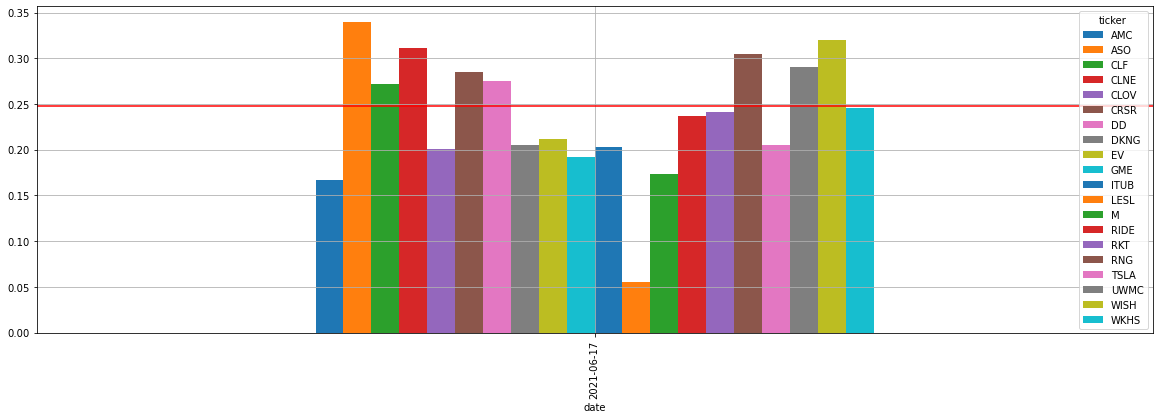

In [179]:
plt.rcParams['figure.figsize'] = [20, 6]

mean_scores.plot(kind = 'bar')

plt.axhline(y=dfSentimentStocks['comment_sentiment_average'].mean(), color='r', linestyle='-')

plt.grid()
plt.show()